In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df.shape #check the number of rows and cols

(40277, 31)

In [4]:
df.info() #checking the types of the data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

In [5]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [6]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [7]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [8]:
df['calendardate'] = pd.to_datetime(df['calendardate'])
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [9]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321467,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504182,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299008571,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710498,0.099426,0.427586,7.010309,1.933891,0.195735


In [10]:
#converting operating margin to a numerical data, apparently there's a bad data, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

In [11]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ', 'GLIBA', 'MRVL', 'NLOK'])] #can drop quick_ratio or drop HTZ, GE

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15152,NLOK,6.180000e+08,1.855,4.592000e+09,1.854700e+10,4.604,3.990000e+08,6.210000e+08,0.995,6.200000e+07,...,3.690000e+09,2.113,1.855,0.223355,0.100324,0.640445,0.991967,12.224326,2.745385,0.247587
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
16554,MRVL,7.176710e+08,1.858,1.439024e+09,1.113324e+10,2.470,5.583800e+07,6.572840e+08,1.092,-1.144950e+08,...,1.584391e+09,0.413,1.858,0.152838,-0.159537,0.083253,1.070033,58.208232,1.605188,0.129255
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,...,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
24871,GLIBA,2.323870e+08,1.207,3.363725e+09,1.193344e+10,3.063,6.491000e+06,1.056511e+08,2.200,-1.644500e+08,...,1.938698e+09,-0.567,1.207,0.180488,-0.707656,0.061438,2.199570,-124.955908,1.731435,0.281874
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,...,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [12]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [13]:
df = df.dropna() #dropping the null values

In [14]:
df.info() #check for infinity how many rows where dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 1 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1493 non-null   object        
 1   revenue                  1493 non-null   float64       
 2   pb                       1493 non-null   float64       
 3   debt                     1493 non-null   float64       
 4   assets                   1493 non-null   float64       
 5   netmargin                1493 non-null   float64       
 6   ncfo                     1493 non-null   float64       
 7   shareswa                 1493 non-null   float64       
 8   sps                      1493 non-null   float64       
 9   opinc                    1493 non-null   float64       
 10  assetsc                  1493 non-null   float64       
 11  liabilitiesc             1493 non-null   float64       
 12  price                    1493 non

In [15]:
#df['calendardate']
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.292488,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735


In [16]:
df.isna().sum() #no nulls 

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [17]:
df = df[~df['ticker'].isin(['AUPH', 'NK', 'ZYME', 'ZGNX', 'LBRDA', 'CRON'])] #filtering rows, dont need ~ AUPH AND NK

In [18]:
#for checking the ticker when needed
df_original = df.copy()

In [19]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'OPER_MARGIN', 'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks.

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
16,0.195382,-65.555556,0.621846,0.035415,-0.347321,-0.243414,10.140,1.454003,1.646590e+08,-0.337
30,0.572629,47.403295,3.514597,1.221921,0.294504,0.134270,23.279,1.672204,2.708000e+09,0.229
51,0.050918,366.601307,0.791419,0.042444,-0.299009,-0.103884,22.487,1.579705,3.191640e+08,-0.288
65,0.195735,7.010309,0.427586,0.099426,0.010710,0.012826,2.931,1.933891,1.975430e+09,-0.009
86,0.050232,156.673511,0.681077,0.132249,0.056058,0.019134,25.289,2.922532,8.339430e+08,0.076


In [20]:
df.corr() #check the correlation between features

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,-0.011830,0.005081,0.019569,0.059346,0.086970,-0.045782,-0.163302,0.004251,0.057880
PX_FREE_CASH_FLOW,-0.011830,1.000000,-0.004949,-0.004619,0.006873,0.052216,0.011264,0.027211,-0.002177,0.006845
REVENUE_PER_SHARE,0.005081,-0.004949,1.000000,0.892516,0.011954,0.034623,-0.003289,-0.036936,0.815334,0.011920
CASH_FLOW_PER_SHARE,0.019569,-0.004619,0.892516,1.000000,0.023717,0.094498,-0.006551,-0.052245,0.889866,0.023553
OPER_MARGIN,0.059346,0.006873,0.011954,0.023717,1.000000,0.342751,-0.011153,-0.068683,0.002987,0.999189
RETURN_ON_ASSET,0.086970,0.052216,0.034623,0.094498,0.342751,1.000000,-0.017487,-0.116341,0.007739,0.346620
PX_TO_BOOK_RATIO,-0.045782,0.011264,-0.003289,-0.006551,-0.011153,-0.017487,1.000000,0.005256,-0.001862,-0.011396
quick_ratio,-0.163302,0.027211,-0.036936,-0.052245,-0.068683,-0.116341,0.005256,1.000000,-0.007687,-0.066979
equity,0.004251,-0.002177,0.815334,0.889866,0.002987,0.007739,-0.001862,-0.007687,1.000000,0.002994
netmargin,0.057880,0.006845,0.011920,0.023553,0.999189,0.346620,-0.011396,-0.066979,0.002994,1.000000


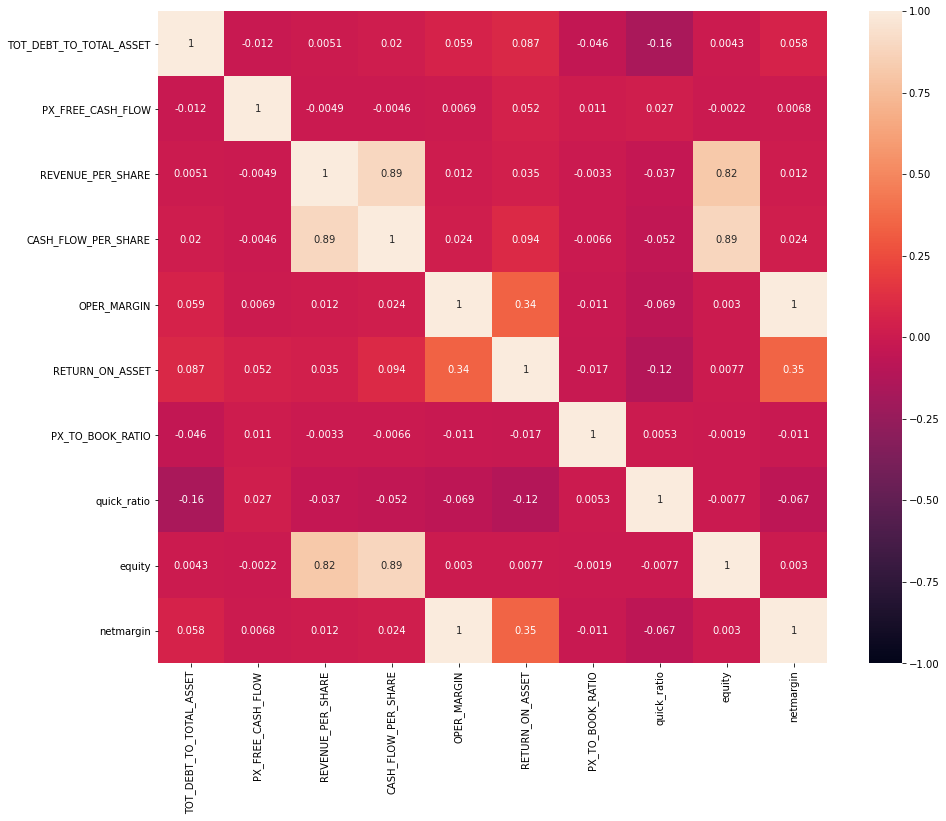

In [21]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [22]:
#dropping the highly correlated columns 

drop_cols = ['equity', 'REVENUE_PER_SHARE', 'OPER_MARGIN']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
16,0.195382,-65.555556,0.035415,-0.243414,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,0.134270,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,-0.103884,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,0.019134,25.289,2.922532,0.076


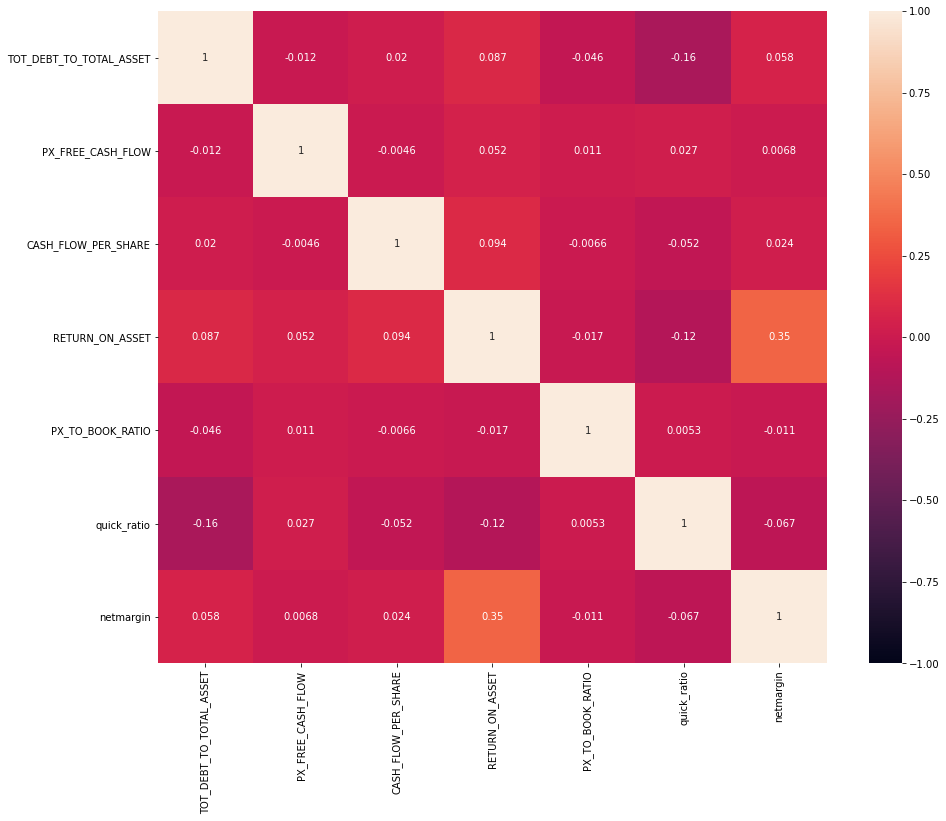

In [23]:
#now the data seems clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [24]:
#assigning X, y
X = df #clean data
y = df_original

In [25]:
y

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


In [26]:
X

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
16,0.195382,-65.555556,0.035415,-0.243414,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,0.134270,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,-0.103884,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,0.019134,25.289,2.922532,0.076
...,...,...,...,...,...,...,...
40154,0.245764,18.533474,2.286520,0.043565,3.090,0.247478,0.045
40175,0.000000,42.303082,0.524823,0.155083,8.872,1.995449,0.131
40217,0.557446,-31.481888,1.369682,0.027648,-106.470,0.313145,0.037
40238,0.123026,13.004837,1.411844,-0.074250,0.971,0.600468,-0.124


In [27]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [28]:
#!pip install yellowbrick
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(df)



In [29]:
#scaling the data to make them all equal on one scale.
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
16,-0.588984,-0.262652,-0.245561,-1.746435,0.089503,-0.128336,0.058100
30,1.013317,0.081077,-0.094707,0.771349,0.298432,-0.063328,0.073174
51,-1.202577,1.052382,-0.244667,-0.816276,0.285838,-0.090886,0.059405
65,-0.587486,-0.041838,-0.237422,-0.038243,-0.025131,0.014635,0.066835
86,-1.205487,0.413581,-0.233249,0.003808,0.330394,0.309177,0.069099


----------------------------------------------------------------------------------------------------


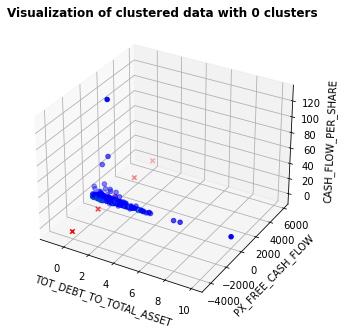

----------------------------------------------------------------------------------------------------


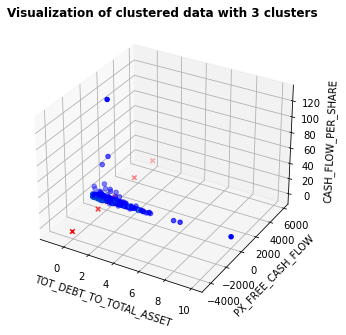

In [30]:

clusters = [0,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

In [32]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

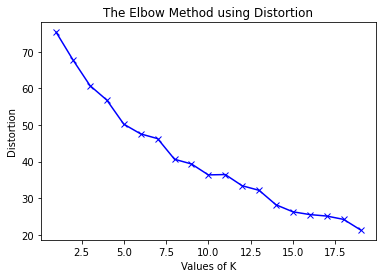

In [33]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [34]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[0 0 5 ... 0 0 0]


In [35]:
pca = PCA(n_components=7).fit_transform(X)
y_pred = KMeans(n_clusters=8, random_state=55).fit_predict(X)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X,
    pca,
    test_size=0.2,
    random_state=55)


plt.figure(figsize = (10,5))
colors = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color = colors[y_pred[i]],
             fontdict = {'weight': 'bold', 'size': 100}
            )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [36]:
pd.Series(kmeans.labels_).value_counts() #check 1, 2,4, 5, 3 for outliers in net margin
#tried the clusters from 7 to 11 and chose 8

0    1398
7      44
5      29
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [37]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters #adding a label to a df
df['label'] = df['label'].astype(str)

In [38]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    #shows the highest 

In [39]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.337486,18.985563,2.050083,0.021969,5.960683,1.855564,-2.675157
1,0.050844,5871.484019,0.258723,-0.035342,14.746000,6.220106,0.005000
2,0.208691,-4346.000000,0.151016,-0.172299,-12.582000,0.478687,-0.040500
3,0.149101,3307.111111,0.323432,-0.046888,6.547500,1.788574,0.016500
4,0.201143,-1299.344666,0.718775,-0.031639,5.613625,2.238599,-0.118875
5,0.336594,537.219073,0.440270,-0.005676,10.675517,1.994138,-0.013586
6,0.693790,6.932384,2.802064,0.080291,-1270.068000,1.211485,0.215500
7,0.258085,-239.463213,0.751288,-0.053252,12.355227,2.578030,-0.098727


In [40]:
#df_original[df['label'] == '5']

In [41]:
from sklearn import preprocessing

In [42]:
df['label'] = kmeans.labels_ 
#df['label'] = df['label'].astype(str)

In [43]:
#normalizing the data for a better and easier understanding of the differences between clusters
#MinMax scaler puts from 0-1

df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0))) 
df['label'] = kmeans.labels_

In [44]:
a = np.array(df['netmargin']) #winsorizing the netmargin, cuz it's very high in value, almost all the data is 0.99

In [45]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.107215,0.458758,0.034660,0.758596,0.599273,0.022720,0.993041
1,0.016152,0.963342,0.027633,0.730420,0.602942,0.077227,0.995603
2,0.066298,0.082423,0.027210,0.663086,0.591529,0.005525,0.995560
3,0.047367,0.742250,0.027887,0.724743,0.599518,0.021884,0.995614
4,0.063900,0.345096,0.029438,0.732240,0.599128,0.027504,0.995485
5,0.106931,0.503439,0.028345,0.745005,0.601242,0.024451,0.995585
6,0.220407,0.457719,0.037610,0.787270,0.066328,0.014677,0.995804
7,0.081990,0.436476,0.029565,0.721614,0.601944,0.031743,0.995504


In [46]:
#from scipy.stats.mstats import winsorize
#import scipy.stats

In [47]:
a

array([0.99527616, 0.99581729, 0.99532301, ..., 0.99563373, 0.9954798 ,
       0.99573698])

In [48]:
pd.Series(kmeans.labels_).value_counts() 

0    1398
7      44
5      29
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [49]:
q = df["netmargin"].quantile(0.90)
df[df["netmargin"] < q]
q_low = df["netmargin"].quantile(0.01)
q_hi  = df["netmargin"].quantile(0.90)

df_filtered = df[(df["netmargin"] < q_hi) & (df["netmargin"] > q_low)]

#at this point I'm trying all the possible ways to see if netmargin values are going to change. My attempts don't end here
#you'll see my attempts below too

In [50]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.107215,0.458758,0.034660,0.758596,0.599273,0.022720,0.993041
1,0.016152,0.963342,0.027633,0.730420,0.602942,0.077227,0.995603
2,0.066298,0.082423,0.027210,0.663086,0.591529,0.005525,0.995560
3,0.047367,0.742250,0.027887,0.724743,0.599518,0.021884,0.995614
4,0.063900,0.345096,0.029438,0.732240,0.599128,0.027504,0.995485
5,0.106931,0.503439,0.028345,0.745005,0.601242,0.024451,0.995585
6,0.220407,0.457719,0.037610,0.787270,0.066328,0.014677,0.995804
7,0.081990,0.436476,0.029565,0.721614,0.601944,0.031743,0.995504


In [51]:
df_original[df_original['netmargin']>2] #looking for outliers in netmargin, took out some of them and dropped them in the
#beginning, before the clustering.
#What I noticed is that the more outliers - companies I dropped the higher the netmargin numbers become. So my assumption is 
#that these tickers are stable, growth companies, that's why the netmargin might be good in comparison with other variables.
#I started to check for outliers from 10 (in the code above), but found outliers from # 7 and went down to 2, removed these tickers too from the clusters.
#They're in a special outliers classification and need futher investigation. 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15152,NLOK,618000000.0,1.855,4.592000e+09,1.854700e+10,4.604,399000000.0,621000000.0,0.995,62000000.0,...,3.690000e+09,2.113,1.855,0.223355,0.100324,0.640445,0.991967,12.224326,2.745385,0.247587
16554,MRVL,717671000.0,1.858,1.439024e+09,1.113324e+10,2.470,55838000.0,657284000.0,1.092,-114495000.0,...,1.584391e+09,0.413,1.858,0.152838,-0.159537,0.083253,1.070033,58.208232,1.605188,0.129255
24871,GLIBA,232387000.0,1.207,3.363725e+09,1.193344e+10,3.063,6491000.0,105651088.0,2.200,-164450000.0,...,1.938698e+09,-0.567,1.207,0.180488,-0.707656,0.061438,2.199570,-124.955908,1.731435,0.281874


In [52]:
df_original[df['label'] == 1] #checking what i have in label 1

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
7953,SHOP,505160000.0,15.206,151707000.0,3.489479e+09,0.002,52888000.0,116060216.0,4.353,-30079000.0,...,-124842000.0,0.073,15.206,-0.043241,-0.059544,0.458527,4.379621,5446.301370,8.046359,0.043476
30098,DDOG,113644000.0,14.286,60426000.0,1.038041e+09,0.008,17430000.0,139873000.0,0.812,-2266000.0,...,-16710000.0,0.006,14.286,-0.027443,-0.019939,0.058919,0.384153,6296.666667,4.393854,0.058212


In [53]:
df_original[df['label'] == 0] #the largest cluster, looking at the similarities in values among variables. 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


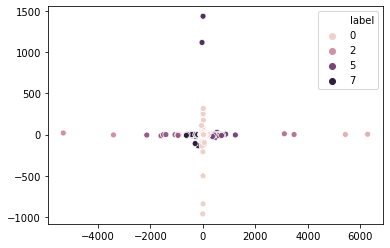

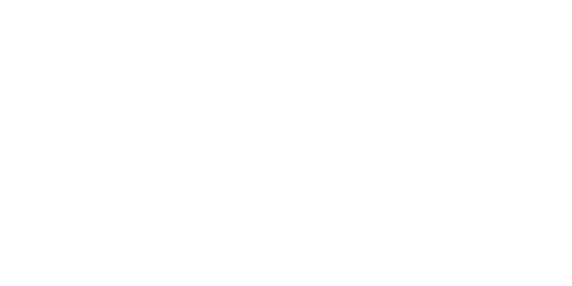

In [54]:
sns.scatterplot(x=pca[:, 0], y = pca[:, 1], hue = df['label'])
plt.figure(figsize = (10,5))
colors = 'rg'


plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [55]:
df[df['label'] == 2] #filtered to row number 1 (cluster) #6 revenue per share is high 9-quick ratio, price for 
#cash flow is high too. #cash flow, quick ratio is okay, #10 is negative but not much debt, all therapies

#netmargin, oper margin 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
23542,0.064297,0.164847,0.027071,0.729354,0.597198,0.008176,0.995564,2
32919,0.068299,0.000000,0.027350,0.596817,0.585859,0.002874,0.995555,2


In [56]:
pd.Series(kmeans.labels_).value_counts() 

0    1398
7      44
5      29
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [57]:
df[df['label'] == 3] #normalized data easy to compare among clusters

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
17015,0.094682,0.72629,0.028530,0.749339,0.597541,0.013964,0.995583,3
33519,0.000052,0.75821,0.027244,0.700147,0.601495,0.029804,0.995645,3


In [58]:
df[df['label'] == 1] 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
7953,0.013812,0.926684,0.028417,0.726536,0.603135,0.100034,0.995600,1
30098,0.018493,1.000000,0.026849,0.734303,0.602750,0.054420,0.995606,1


In [59]:
df[df['label'] == 5] #filtering, df['label'] gives true and falses

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
51,0.016176,0.488729,0.026785,0.696721,0.606176,0.019275,0.995323,5
1666,0.115752,0.486682,0.032896,0.764073,0.597985,0.004311,0.995718,5
3943,0.155384,0.518958,0.029334,0.771854,0.597986,0.005142,0.995692,5
4048,0.034814,0.508025,0.024178,0.786769,0.604778,0.018626,0.995824,5
9062,0.117162,0.502677,0.028137,0.758015,0.598012,0.007567,0.995683,5
9627,0.090966,0.515997,0.026330,0.724306,0.604712,0.020617,0.995503,5
12458,0.039262,0.565235,0.027154,0.786948,0.601714,0.040050,0.995662,5
13723,0.177448,0.492850,0.027422,0.677584,0.612775,0.034552,0.995310,5
14411,0.108379,0.500890,0.026894,0.739430,0.612777,0.059774,0.995639,5
15508,0.134485,0.486939,0.025695,0.714176,0.601103,0.035131,0.995428,5


In [60]:
df[df['label'] == 7]  #profitable and cheap but have higher debt

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
1185,0.049986,0.445591,0.026693,0.521803,0.603507,0.022435,0.995131,7
2759,0.015707,0.438461,0.026762,0.720611,0.599162,0.127691,0.995358,7
3812,0.015582,0.425516,0.026891,0.705715,0.604074,0.100539,0.995508,7
3915,0.039489,0.436404,0.026962,0.716812,0.598099,0.100923,0.995338,7
5648,0.034726,0.419570,0.026636,0.788436,0.601549,0.052588,0.995670,7
7510,0.025911,0.436327,0.026617,0.677734,0.601411,0.032968,0.995255,7
8058,0.109885,0.445480,0.028376,0.758400,0.599928,0.010048,0.995585,7
8899,0.054236,0.431553,0.036537,0.788928,0.598021,0.009712,0.995644,7
9485,0.086713,0.436170,0.026265,0.716911,0.606193,0.029174,0.995562,7
10533,0.147918,0.433182,0.026772,0.707150,0.601082,0.015926,0.995426,7


In [61]:
df[df['label'] == 4] #cheaper than 7, no cash flow, profitable = oper margin, not diff with 7 but cheap, good for investments

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
10452,0.000000,0.367025,0.027534,0.689756,0.597973,0.072406,0.995243,4
11143,0.086812,0.321171,0.027816,0.679353,0.603166,0.023179,0.995349,4
17724,0.097522,0.329046,0.033258,0.769579,0.597657,0.012564,0.995664,4
18736,0.066480,0.379605,0.029991,0.746576,0.598252,0.017921,0.995508,4
22325,0.000000,0.375642,0.035890,0.778054,0.597957,0.024419,0.995660,4
27503,0.163257,0.376981,0.026788,0.700404,0.601785,0.044401,0.995378,4
33576,0.037377,0.274234,0.027327,0.753862,0.598951,0.012754,0.995592,4
35984,0.059754,0.337065,0.026897,0.740336,0.597284,0.012384,0.995484,4


In [62]:
df[df['label'] == 6] #cost is higher = px free cash flow, 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
18946,0.279779,0.456019,0.038029,0.757053,0.132655,0.024924,0.995897,6
20236,0.161036,0.459420,0.037192,0.817486,0.000000,0.004429,0.995712,6


In [63]:
df[df['label'] == 0] 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
16,0.062070,0.451470,0.026757,0.628123,0.601019,0.017705,0.995276,0
30,0.181916,0.461208,0.031412,0.813808,0.606506,0.020430,0.995817,0
65,0.062182,0.457726,0.027008,0.754101,0.598008,0.023698,0.995590,0
86,0.015958,0.470629,0.027137,0.757202,0.607346,0.036045,0.995671,0
159,0.123490,0.474417,0.027744,0.690130,0.604623,0.015497,0.995448,0
...,...,...,...,...,...,...,...,...
40154,0.078076,0.458719,0.035588,0.769214,0.598074,0.002638,0.995641,0
40175,0.000000,0.460769,0.028677,0.824040,0.600489,0.024467,0.995724,0
40217,0.177093,0.454407,0.031991,0.761388,0.552315,0.003458,0.995634,0
40238,0.039084,0.458243,0.032157,0.711291,0.597189,0.007046,0.995480,0


----------------------------------------------------------------------------------------------------


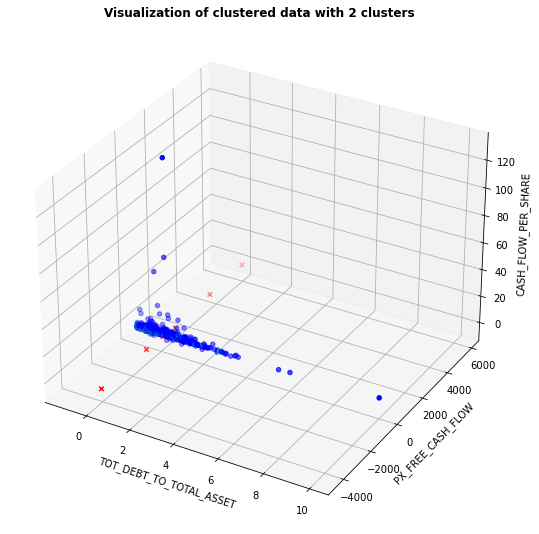

----------------------------------------------------------------------------------------------------


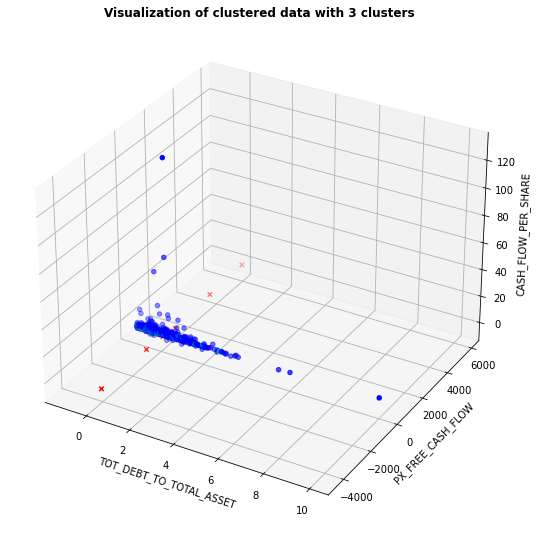

In [64]:
#Let's get to the fun part, visualizing our clusters! This will involve, in the non-PCA case, creating another 3D scatter plot,
#but in this instance,
#we will define the c parameter of our scatter to equal our model labels. This will correctly create the clusters for us.

clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [81]:
#let's see the other method of clustering: GaussianMixture, all the steps that i did above can be applied here too.

gauss = GaussianMixture(n_components=8, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=8, random_state=55)

In [82]:
gauss.means_

array([[ 3.45838420e-01, -5.48479124e+01,  4.08574800e+00,
        -1.31271163e-01,  1.64506780e+01,  4.80772770e+00,
        -2.10485023e+01,  1.70126979e+00],
       [ 5.08435595e-02,  5.87148402e+03,  2.58722870e-01,
        -3.53421060e-02,  1.47460000e+01,  6.22010643e+00,
         5.00000000e-03,  1.00000000e+00],
       [ 2.08690621e-01, -4.34600000e+03,  1.51016125e-01,
        -1.72298894e-01, -1.25820000e+01,  4.78686699e-01,
        -4.05000000e-02,  2.00000000e+00],
       [ 2.01142752e-01, -1.29934467e+03,  7.18775209e-01,
        -3.16393510e-02,  5.61362500e+00,  2.23859937e+00,
        -1.18875000e-01,  4.00000000e+00],
       [ 1.49101350e-01,  3.30711111e+03,  3.23432113e-01,
        -4.68881770e-02,  6.54750000e+00,  1.78857384e+00,
         1.65000000e-02,  3.00000000e+00],
       [ 3.36593891e-01,  5.37219073e+02,  4.40269513e-01,
        -5.67581231e-03,  1.06755172e+01,  1.99413758e+00,
        -1.35862069e-02,  5.00000000e+00],
       [ 6.93790215e-01,  6.932384

In [83]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1487, 8)

In [84]:
centroids = df.groupby(['label']).mean()

In [85]:
centroids.style.background_gradient() 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.106609,0.458971,0.034388,0.757263,0.598668,0.023013,0.993168
1,0.016152,0.963342,0.027633,0.730420,0.602942,0.077227,0.995603
2,0.068299,0.000000,0.027350,0.596817,0.585859,0.002874,0.995555
3,0.063944,0.325068,0.029175,0.731919,0.598914,0.025356,0.995494
4,0.047367,0.742250,0.027887,0.724743,0.599518,0.021884,0.995614


In [86]:
df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0)))

In [87]:
gauss = GaussianMixture(n_components=5, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=5, random_state=55)

In [88]:
gauss.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [89]:
df['label'] = gauss.predict(X)

In [90]:
centroids = df.groupby(['label']).mean()

In [91]:
centroids.style.background_gradient() 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.106609,0.458971,0.034388,0.757263,0.598668,0.023013,0.993168
1,0.016152,0.963342,0.027633,0.730420,0.602942,0.077227,0.995603
2,0.068299,0.000000,0.027350,0.596817,0.585859,0.002874,0.995555
3,0.063944,0.325068,0.029175,0.731919,0.598914,0.025356,0.995494
4,0.047367,0.742250,0.027887,0.724743,0.599518,0.021884,0.995614


In [92]:
scipy.stats.entropy([0.731826, 0.267606, 5.687710e-04])


0.5855042262910504

In [93]:
prob_df['entropy'] = prob_df.apply(scipy.stats.entropy, axis=1)

In [94]:
prob_df.sort_values('entropy')

,0,1,2,3,4,5,6,7,entropy
611,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
979,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1385,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
983,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
337,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
585,0.225188,0.0,0.0,0.0,0.0,0.0,0.0,0.774812,0.533396
1458,0.229873,0.0,0.0,0.0,0.0,0.0,0.0,0.770127,0.539123
837,0.750673,0.0,0.0,0.0,0.0,0.0,0.0,0.249327,0.561595
525,0.664687,0.0,0.0,0.0,0.0,0.0,0.0,0.335313,0.637877


In [95]:
df_original #have to add a new column 'label' to be able to see it on the plot in the original DF

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


In [130]:
df_original['label'] = kmeans.labels_ #adding a new column 'label' to the original df

In [131]:
from ipywidgets import interact

In [133]:
px.scatter(data_frame=df_original, x='TOT_DEBT_TO_TOTAL_ASSET', y='PX_TO_BOOK_RATIO', color = 'label', hover_data=['ticker', 'netmargin', 'PX_FREE_CASH_FLOW'])

In [134]:
df_original #see the label col in the end:)

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382,0
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,0
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918,5
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,0
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,0
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,0
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446,0
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,0


In [136]:
#probably can work in collab, notebook in slides Friday, code for collab there. 

@interact
def plotting(x=df_original.columns, y = df_original.columns):
    fig = px.scatter(data_frame=df_original, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

interactive(children=(Dropdown(description='x', options=('ticker', 'revenue', 'pb', 'debt', 'assets', 'netmarg…

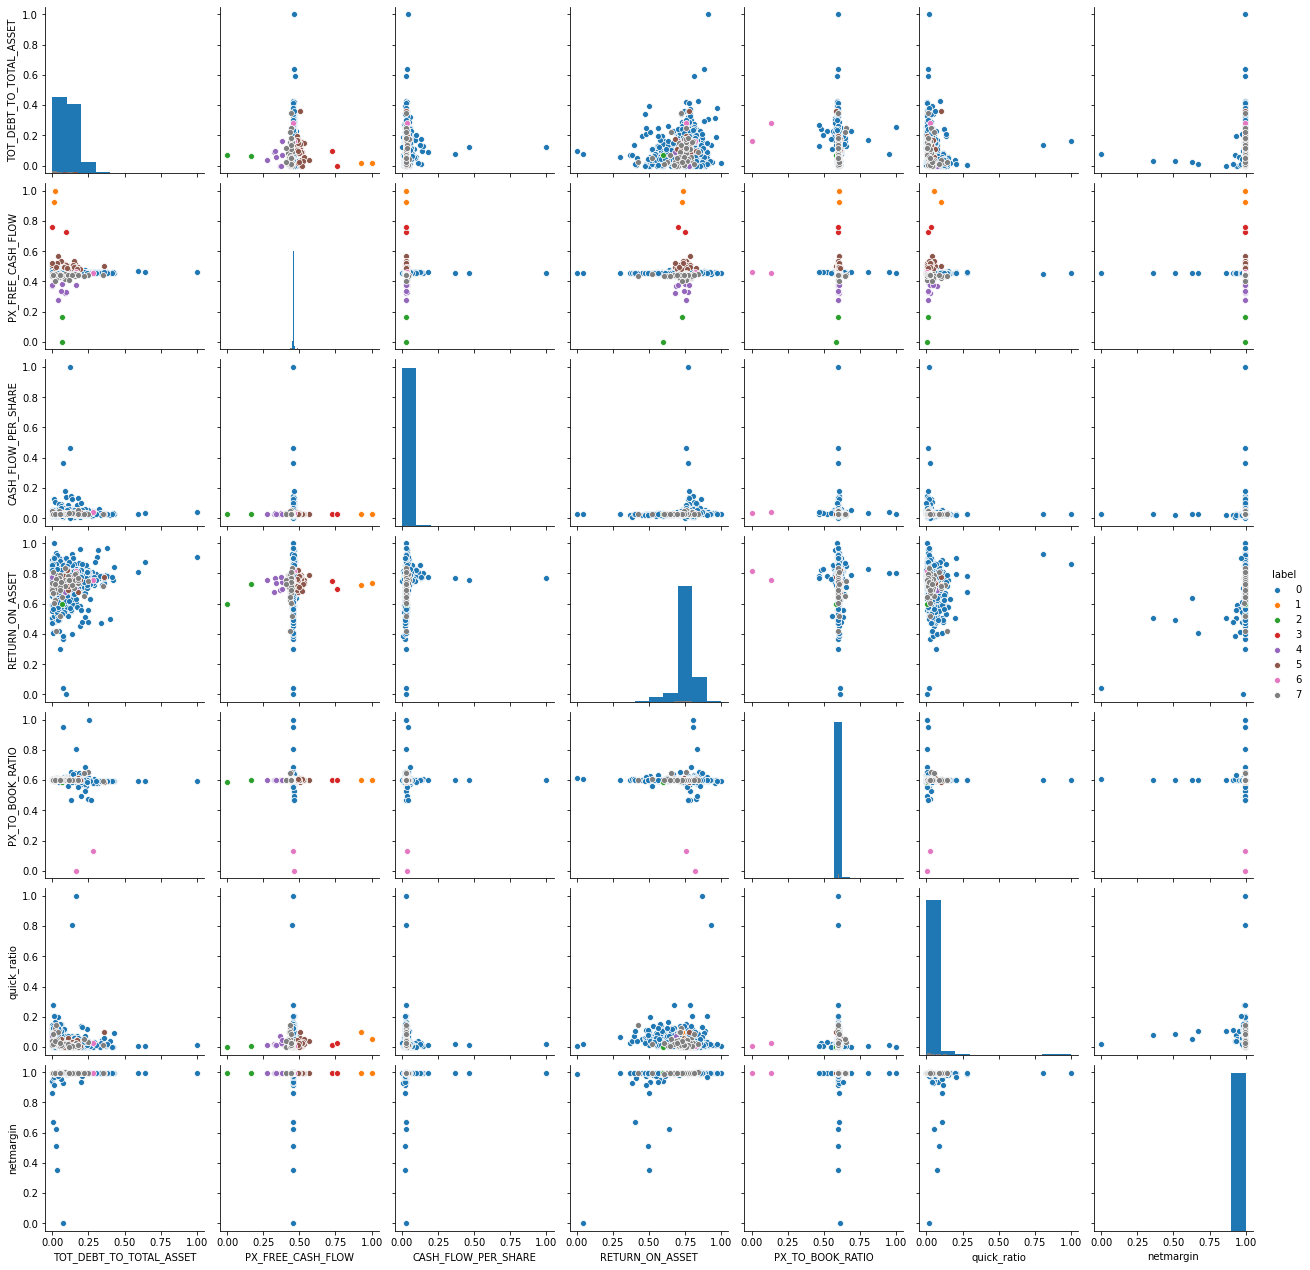

In [142]:
sns.pairplot(df, hue="label", diag_kind="hist")
#very interesting.. We can actually see the clusters very distintcly at some plots.
#amazing tool for futher investigation. 

find a plot where i can see distinct clusters.

In [ ]:
set(y_pred) #no repeated list = set

In [ ]:
df.info()

In [ ]:
#df['OPER_MARGIN'] = df['OPER_MARGIN'].str.replace('\', '').astype(int)

In [ ]:
#df['OPER_MARGIN'] = float('OPER_MARGIN')

In [ ]:
#float("OPER_MARGIN")

In [ ]:
df.['OPER_MARGIN']['6']

PCA ON KMENS DO IT
NORMALIZED ON GAUSSIANMIXTURE TOO
THEN PCA ON GAUSSIAN


#winsorize, pca, visuals for clusters = each group, performance with rand_index, 
#winsorize
PCA and get the visuals for each group
Performance of your clusteing adjusted rand index
GAUSSIAN
if i have time NON-linearity check it out, TSNE. reduce the data to 2, visualize, cluster. 

explain with small clusters. 

Keep the following considerations in mind: How do clustering and modeling compare? (Kmeans,Gaussian) two different results and whats best and worst. 
What are the advantages of each? Why would you want to use one over the other?

 Jupyter's built-in slide deck capabilities.
 
 
The visuals that you chose and what they represent for your research
Next steps that you'd take to expand on your work - visuals and next i tell what to do with this, groups of similar stocks: long, short, quick, data trade clusters. Make names for clusters on their similarities. 

A specified research question that your model addresses - can we group stocks? think of it.

How you chose your model specification and what alternatives you compared it to

In [ ]:
fORMAL WAYS TO EVALUATING CLUSTERS. RAND INDEX